In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import openai
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns
import numpy as np
from pretty_confusion_matrix import pp_matrix_from_data

## Data setup

### Data export to jsonl

In [2]:
EXPORT_FILE_NAME = "export.jsonl"

MAP = {0.0: 'good', 1.0: 'bad'}

def create_export():
    reviews = pd.read_csv('../german_doctor_reviews_graded.csv', sep=';')

    frame = (reviews
             .assign(prompt=lambda df: df.comment + '###')
             .assign(completion=lambda df: ' ' + df.label.replace(MAP))
             .drop_duplicates()
             )[['prompt', 'completion']]

    frame.to_json(EXPORT_FILE_NAME, orient='records', lines=True)


create_export()

### Openai data preparation and splitting

In [3]:
!openai tools fine_tunes.prepare_data -f export.jsonl -q

Analyzing...

- Your file contains 9994 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- All prompts end with suffix `###`

No remediations found.
- [Recommended] Would you like to split into training and validation set? [Y/n]: Y


Your data will be written to a new JSONL file. Proceed [Y/n]: Y

Wrote modified files to `export_prepared_train (1).jsonl` and `export_prepared_valid (1).jsonl`
Feel free to take a look!

Now use that file when fine-tuning:
> openai api fine_tunes.create -t "export_prepared_train (1).jsonl" -v "export_prepared_valid (1).jsonl" --compute_classification_metrics --classification_positive_class " good"

After you’ve fine-tuned a model, remember that your prompt has to end wi

## Fine tuning GPT3

In [6]:
!export OPENAI_API_KEY=

In [4]:
! openai api fine_tunes.create \
-t "export_prepared_train.jsonl" \
-v "export_prepared_valid.jsonl" \
--compute_classification_metrics \
--classification_positive_class " good" \
--model ada

Found potentially duplicated files with name 'export_prepared_train.jsonl', purpose 'fine-tune' and size 3771000 bytes
file-Js1NSuxTtaPjTYsRn2HoU0GP
Enter file ID to reuse an already uploaded file, or an empty string to upload this file anyway: ^C



In [5]:
! openai api fine_tunes.follow -i ft-0CRziZIUHiFAFgiwgBzzc9UK

[2022-10-05 08:43:49] Created fine-tune: ft-0CRziZIUHiFAFgiwgBzzc9UK
[2022-10-05 08:44:00] Fine-tune costs $2.14
[2022-10-05 08:44:00] Fine-tune enqueued. Queue number: 0
[2022-10-05 08:44:01] Fine-tune started
[2022-10-05 08:48:31] Completed epoch 1/4
[2022-10-05 08:53:13] Completed epoch 2/4
[2022-10-05 08:57:48] Completed epoch 3/4
[2022-10-05 09:02:23] Completed epoch 4/4
[2022-10-05 09:03:11] Uploaded model: ada:ft-personal-2022-10-05-07-03-11
[2022-10-05 09:03:12] Uploaded result file: file-Q5HvtQlyEOOUKTt9ZGDXATS4
[2022-10-05 09:03:12] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-personal-2022-10-05-07-03-11 -p <YOUR_PROMPT>


## Model inference

In [6]:
!openai api completions.create \
-m ada:ft-personal-2022-10-05-07-03-11 -M 1 \
-p "Auch sie war total begeistert###"

Auch sie war total begeistert### good

## Model evaluation

In [7]:
!openai api fine_tunes.results -i ft-0CRziZIUHiFAFgiwgBzzc9UK > result.csv 

In [8]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
2249,2250,17329184,36000,0.008239,0.875,0.875,NaN,NaN,NaN,0.976,0.987356,0.985092,0.992725,0.998798,0.986223


Text(0, 0.5, 'classification/accuracy')

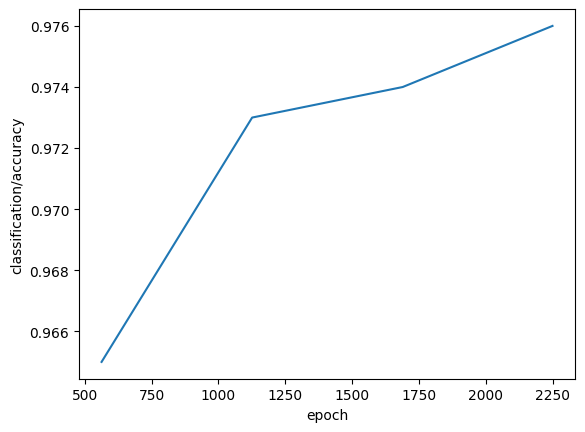

In [10]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()
plt.xlabel('epoch')
plt.ylabel('classification/accuracy')

In [11]:
api_key = open('.env').readline().split('=')[-1]
openai.api_key = api_key

In [12]:
FINE_TUNED_MODEL = 'ada:ft-personal-2022-10-05-07-03-11'

In [13]:
PROMPT = """
Frau Dr. Vetter kenne ich seit vielen Jahren, sie hat mir bei vielen Problemen sehr kompetent und sehr <br />
umsichtig geholfen. Sie hat mich immer aufgerichtet, wenn es mir schlecht ging.Und sie hat auch viel Ahnung von anderen Fachgebieten. Ich bin sehr zufrieden und kann sie nur wärmstens empfehlen.<br />
Gestern war ich mit meiner Tochter bei ihr . Auch sie war total begeistert.
"""

In [14]:
def invoke_model(*prompts):
    prompts = [prompt + '###' for prompt in prompts]
    
    response = openai.Completion.create(
        model=FINE_TUNED_MODEL,
        prompt=prompts,
        max_tokens=1,
        temperature=0)
    return [choice['text'] for choice in response['choices']]

In [15]:
invoke_model(PROMPT)

[' good']

### Validationset

In [16]:
validation_frame = pd.read_json('export_prepared_valid.jsonl', lines=True)
#validation_frame =  validation_frame.sample(100, random_state=123456)
validation_frame

,prompt,completion
0,"Frau Dr. Vetter kenne ich seit vielen Jahren, ...",good
1,Dieser Mann weiss was er tut.###,good
2,Man ist mit seinen zahnen sehr gut aufgehoben.###,good
3,Ausgesprochen gewissenhafter und kompetenter Z...,good
4,Ich bin jetzt seit bestimmt 5 Jahren Patient. ...,good
...,...,...
995,Ich bin schon seit mehreren Jahren bei Frau Dr...,good
996,Die Wartezeiten mögen ja recht lange sein (kan...,good
997,Dr. Schüßeler ist einer der unfreundlichsten Ä...,bad
998,"Bei Herrn Soulis gefällt mir am besten, dass e...",good


In [17]:
prompts = validation_frame.prompt.to_list()
y_true = validation_frame.completion.to_list()

In [20]:
results = invoke_model(*prompts)

In [21]:
y_pred = [res if res in [' good', ' bad'] else ' bad' for res in results]

In [22]:
pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T.applymap("{0:.2f}".format)

,precision,recall,f1-score,support
bad,0.89,0.91,0.90,128.00
good,0.99,0.98,0.99,872.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.94,0.95,0.94,1000.00
weighted avg,0.98,0.97,0.98,1000.00


In [23]:
cf_matrix = confusion_matrix(y_true, y_pred)

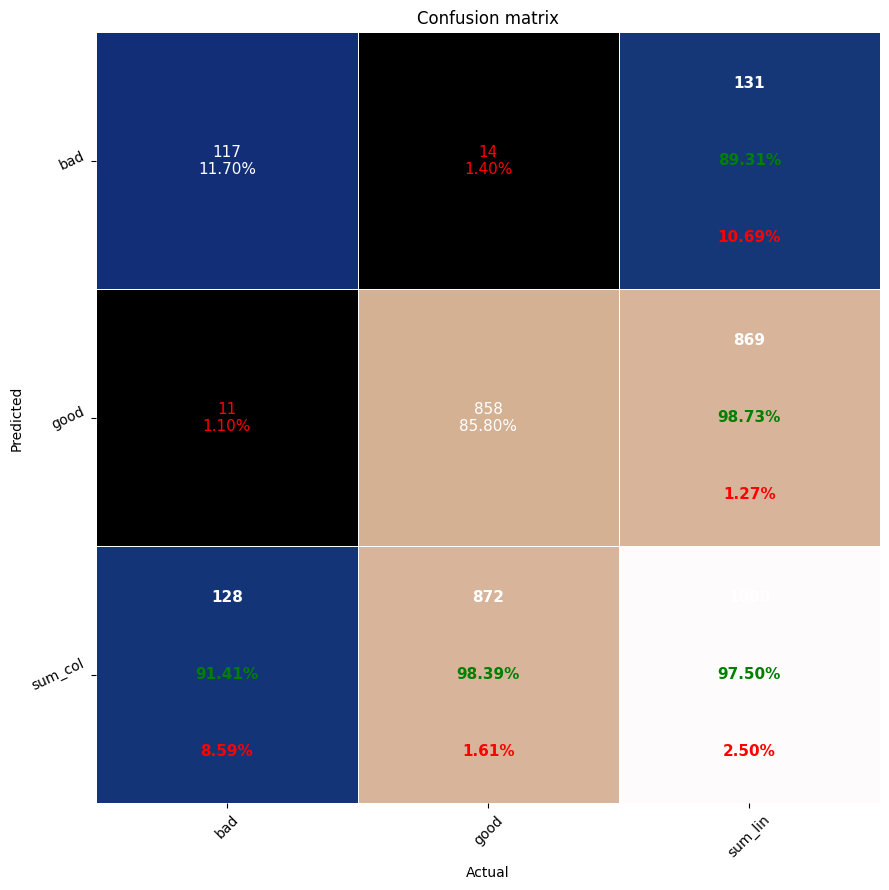

In [24]:
pp_matrix_from_data(y_true, y_pred, columns=['bad', 'good'], cmap = 'gist_earth')